# Introduction

Multi-stage OPF with renewable generations.

Renewable generations are treated as negative load at each buses.

Test case is shown for one day 2016-08-12.

# Packages

In [1]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypower.api as pp
from datetime import datetime
import nygrid.opf as opf


# Read data

## Electricity demand data

In [2]:
start_date = datetime(2016, 8, 5, 0, 0, 0)
end_date = datetime(2016, 8, 16, 0, 0, 0)

# Read load profile
data_dir = '../data'
filename = os.path.join(data_dir, f'loadprofile_{start_date.year}.csv')
load_profile = pd.read_csv(filename, parse_dates=['TimeStamp'], index_col='TimeStamp')

load_profile = load_profile.loc[start_date:end_date, :]
load_profile.head()

,Bus21,Bus29,Bus35,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,...,Bus81,Bus82,Bus100,Bus102,Bus103,Bus124,Bus125,Bus132,Bus134,Bus138
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2016-08-05 00:00:00,120.877006,7248.817322,2363.056640,-7.886435,7.032042e-13,214.10,-2.103049,1119.140870,273.635365,-12.242176,...,3075.55,3075.55,864.066076,35.228039,9899.663525,2509.193258,1161.990148,11657.674187,-620.241123,251.053648
2016-08-05 01:00:00,124.632025,6829.183228,2249.901513,-7.953733,1.086023e-12,199.68,-2.120995,1061.349031,258.942522,-13.663576,...,2918.90,2918.90,809.810448,-6.671941,9408.830116,2357.188672,1097.490864,11059.960139,-604.810703,236.692103
2016-08-05 02:00:00,137.253830,6517.097493,2187.066772,-7.833859,1.267025e-12,190.40,-2.089029,1026.395933,250.246461,-14.982986,...,2804.75,2804.75,764.177167,-76.821095,9122.624662,2265.856916,1054.365603,10613.784413,-572.174035,227.819043
2016-08-05 03:00:00,124.641375,6379.870272,2118.640241,-7.957939,7.478021e-13,184.20,-2.122117,1008.908649,245.677611,-15.392569,...,2738.20,2738.20,720.043592,-199.676975,9047.437211,2190.696746,1026.736854,10394.315830,-578.988478,221.406144
2016-08-05 04:00:00,135.115125,6340.251988,2130.255897,-7.964248,1.340975e-12,182.44,-2.123800,1014.734963,247.143358,-15.104404,...,2731.25,2731.25,707.357261,-254.545019,9095.542449,2176.517721,1023.791479,10394.844608,-588.481001,220.551626


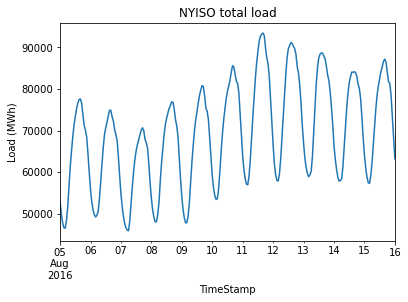

In [3]:
total_load = load_profile.sum(axis=1)
total_load.plot()
plt.ylabel('Load (MWh)')
plt.title('NYISO total load')
plt.show()

# Renewable energy data

In [4]:
# Read solar generation at each bus
solar_gen = pd.read_csv(os.path.join(data_dir, 'solar_20160805_20160816.csv'), 
                        parse_dates=['TimeStamp'], index_col='TimeStamp')
# Convert time zone
solar_gen.index = solar_gen.index.tz_localize('UTC').tz_convert('US/Eastern').tz_localize(None)


# Read wind generation at each bus
wind_gen = pd.read_csv(os.path.join(data_dir, 'wind_20160805_20160816.csv'),
                        parse_dates=['TimeStamp'], index_col='TimeStamp')
# Convert time zone
wind_gen.index = wind_gen.index.tz_localize('UTC').tz_convert('US/Eastern').tz_localize(None)


<AxesSubplot:xlabel='TimeStamp'>

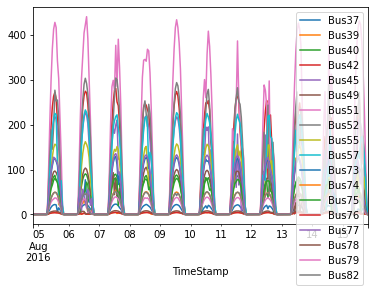

In [5]:
solar_gen.plot()

<AxesSubplot:xlabel='TimeStamp'>

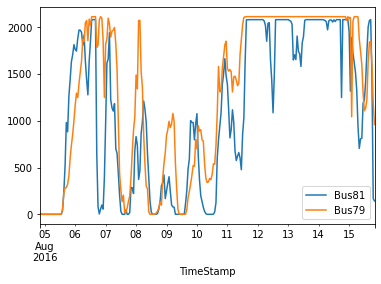

In [6]:
wind_gen.plot()

In [7]:
load_profile_new = load_profile.copy()

# Treat solar and wind generation as net load
for bus in load_profile_new.columns:
    # If there is solar generation at that bus
    if bus in solar_gen.columns:
        load_profile_new[bus] = load_profile_new[bus] - solar_gen[bus]

    # If there is wind generation at that bus
    if bus in wind_gen.columns:
        load_profile_new[bus] = load_profile_new[bus] - wind_gen[bus]


# Multi-period OPF

In [8]:
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
num_day = len(timestamp_list) - 1

# Only run for one day
d = 7
start_time = timestamp_list[d]
end_time = timestamp_list[d+1]
print(f'Start time: {start_time}')
print(f'End time: {end_time}')
load = load_profile_new.loc[start_time:end_time, :].to_numpy()

Start time: 2016-08-12 00:00:00
End time: 2016-08-13 00:00:00


In [9]:
# Read MATPOWER case file
filename = os.path.join(data_dir, 'ny_grid.mat')
ppc = pp.loadcase(filename)

(ppc_int, B, Bf, gen_map, load_map, load_pu, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
    gen_min, gen_max, br_min, br_max, ramp_down, ramp_up, if_map, if_lims) = opf.process_ppc(ppc, load)

In [10]:
# Multi-period OPF
model_multi = opf.multi_opf(B, Bf, gen_map, load_map, load_pu, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
                gen_min, gen_max, br_min, br_max, ramp_down, ramp_up, if_map, if_lims)



In [11]:
# model_multi.c_br_min.deactivate()
# model_multi.c_br_max.deactivate()
# Solve the problem
solver = SolverFactory('gurobi')
results_multi = solver.solve(model_multi, tee=True)

if opf.check_model_status(results_multi):
     print('%.2f' % model_multi.obj())

Academic license - for non-commercial use only - expires 2023-07-21
Using license file C:\Users\xjtuy\gurobi.lic
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmplubld3ag.pyomo.lp
Reading time = 0.11 seconds
x10701: 36095 rows, 10701 columns, 66539 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 36095 rows, 10701 columns and 66539 nonzeros
Model fingerprint: 0xb2c97899
Coefficient statistics:
  Matrix range     [1e-01, 5e+02]
  Objective range  [1e+02, 9e+05]
  Bounds range     [6e+00, 6e+00]
  RHS range        [8e-17, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 31342 rows and 4523 columns
Presolve time: 0.03s
Presolved: 4753 rows, 9282 columns, 21788 nonzeros

Ordering time: 0.05s

Barrier statistic

# Process the results

In [12]:
results = opf.opf_results_multi(model_multi, ppc_int, start_time, end_time)

In [13]:
results.keys()

dict_keys(['PG', 'VA', 'PF', 'IF', 'LMP'])

In [14]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.591500,-74.202700,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.591500,-74.202700,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.786900,-73.912200,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.786900,-73.912200,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Shoreham 1,23715,K,Combustion Turbine,Fuel Oil 2,40.957200,-72.866400,52.9,0.0,0.881667,8.816667,26.45,52.9,0.000000,0.000000,80,1,195.331050,0.000000
223,Shoreham 2,23716,K,Jet Engine,Fuel Oil 2,40.957200,-72.866400,18.6,0.0,0.310000,3.100000,9.30,18.6,0.000000,0.000000,80,1,195.331050,0.000000
224,South Cairo,23612,G,Combustion Turbine,Kerosene,42.291275,-73.986452,21.6,0.0,0.360000,3.600000,10.80,21.6,0.000000,0.000000,39,1,195.331050,0.000000
225,Southold 1,23719,K,Combustion Turbine,Fuel Oil 2,41.105900,-72.376100,14.0,0.0,0.233333,2.333333,7.00,14.0,0.000000,0.000000,80,1,195.331050,0.000000


In [15]:
num_thermal = gen_info.shape[0]
results_pg = results['PG']
thermal_pg = results_pg.iloc[:, :num_thermal]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
thermal_pg = thermal_pg.rename(columns=gen_rename)
thermal_pg

,Allegany,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,Astoria 3,Astoria 5,Astoria CC 1,Astoria CC 2,Astoria East Energy - CC1,Astoria East Energy - CC2,...,Northport GT,Ravenswood 01,Ravenswood 10,Ravenswood 11,S Hampton 1,Shoreham 1,Shoreham 2,South Cairo,Southold 1,St. Elizabeth Medical Center
2016-08-12 00:00:00,66.0,349.0,539.0,49.5,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 01:00:00,66.0,349.0,539.0,1.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-12 02:00:00,22.0,349.0,539.0,1.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-12 03:00:00,11.0,349.0,539.0,1.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-12 04:00:00,11.0,349.0,539.0,1.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-12 05:00:00,22.0,349.0,539.0,7.5,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-12 06:00:00,66.0,349.0,539.0,56.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 07:00:00,66.0,349.0,539.0,104.5,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 08:00:00,66.0,349.0,539.0,153.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 09:00:00,66.0,349.0,539.0,153.0,40.0,2.00000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6


<AxesSubplot:>

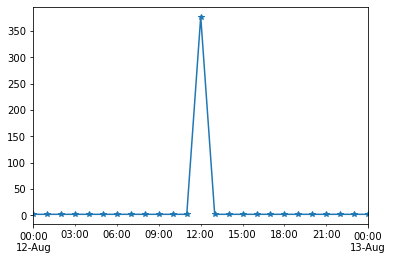

In [16]:
thermal_pg['Astoria 5'].plot(marker='*')

In [17]:
# Save thermal generation to a csv file
resultsdir = '../results'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)
basename = f'thermal_with_renewable_{start_time.strftime("%Y%m%d%H%M")}_{end_time.strftime("%Y%m%d%H%M")}.csv'
filename = os.path.join(resultsdir, basename)
thermal_pg.to_csv(filename)
print(f'Saved thermal generation results in {filename}')

Saved thermal generation results in ../results\thermal_with_renewable_201608120000_201608130000.csv
